<a href="https://colab.research.google.com/github/Singati2/AI_Science_Medicine/blob/main/Hahn_2023_Turtle_Net_Simple_98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-wivzitgr
  Running command git clone --filter=blob:none --quiet https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-wivzitgr
  Resolved https://github.com/williamedwardhahn/mpcr to commit 8d265643f3b8b6e0ed96c7fb98da047fdcd3bb51
  Preparing metadata (setup.py) ... done
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-py3-none-any.whl size=7664 sha256=c5e4bbee47f4c48cb7102f96c59450f6aafecd125a188eb376d1307f8fc6a391
  Stored in directory: /tmp/pip-ephem-wheel-cache-_4x_j1j9/wheels/ea/02/e0/f5ddcc5cf9849058373052ecb328f3e9843fac4141b8491e0f
Successfully built ImportMPCR


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
def softmax(x):
    s1 = torch.exp(x - torch.max(x,1)[0][:,None])
    s = s1 / s1.sum(1)[:,None]
    return s

In [3]:
def cross_entropy(outputs, labels):            
    return -torch.sum(softmax(outputs).log()[range(outputs.size()[0]), labels.long()])/outputs.size()[0]  

In [4]:
def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0 
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)

In [5]:
def acc(out,y):
    with torch.no_grad():
        return (torch.sum(torch.max(out,1)[1] == y).item())/y.shape[0]

In [6]:
def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))

def GPU_data(data):
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=torch.device('cuda'))

In [7]:
def plot(x):
    if type(x) == torch.Tensor :
        x = x.cpu().detach().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(10, 10)
    plt.show()

In [8]:
def montage_plot(x):
    x = np.pad(x, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)
    plot(montage(x))

In [9]:
#MNIST
train_set = datasets.MNIST('./data', train=True, download=True)
test_set = datasets.MNIST('./data', train=False, download=True)

#KMNIST
# train_set = datasets.KMNIST('./data', train=True, download=True)
# test_set = datasets.KMNIST('./data', train=False, download=True)

#Fashion MNIST
# train_set = datasets.FashionMNIST('./data', train=True, download=True)
# test_set = datasets.FashionMNIST('./data', train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 392434717.20it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 63091507.20it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 99075860.93it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20528587.03it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Label	Description
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot

In [10]:
X = train_set.data.numpy()
X_test = test_set.data.numpy()
Y = train_set.targets.numpy()
Y_test = test_set.targets.numpy()

X = X[:,None,:,:]/255
X_test = X_test[:,None,:,:]/255

In [11]:
X.shape,Y.shape,X_test.shape,Y_test.shape

((60000, 1, 28, 28), (60000,), (10000, 1, 28, 28), (10000,))

In [12]:
X.shape

(60000, 1, 28, 28)

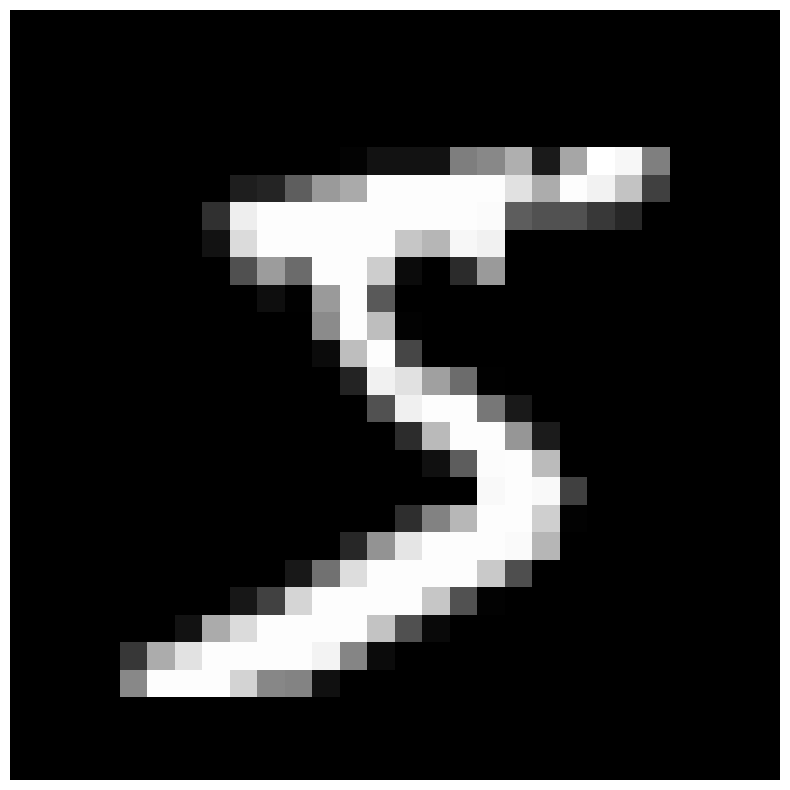

In [13]:
plot(X[0,0,:,:])

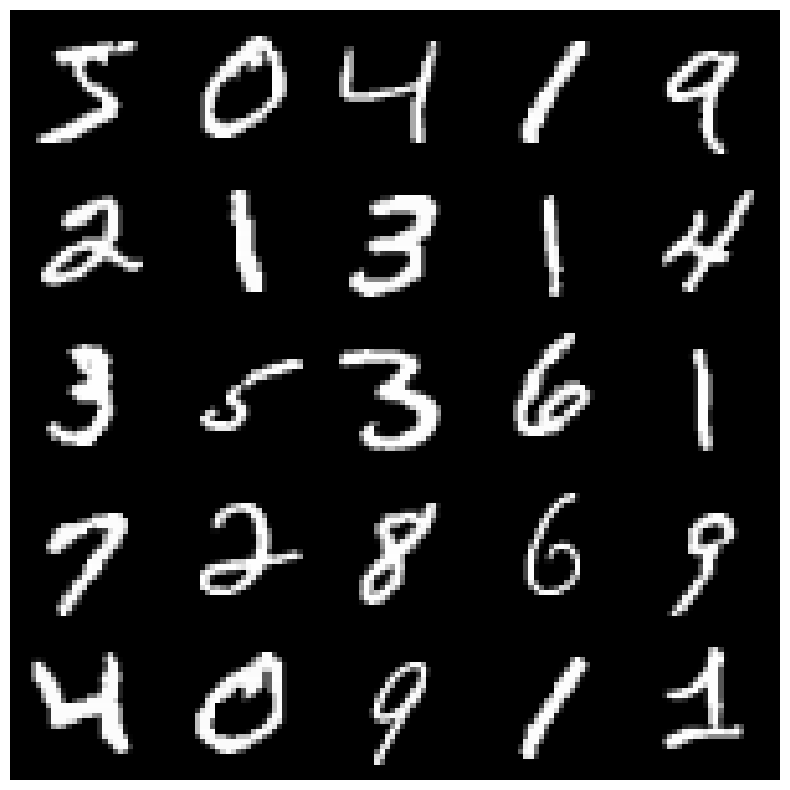

In [14]:
montage_plot(X[0:25,0,:,:])

In [ ]:
###################################################

In [ ]:
X = GPU_data(X)
Y = GPU_data(Y)
X_test = GPU_data(X_test)
Y_test = GPU_data(Y_test)

In [ ]:
def get_batch(mode):
    b = c.b
    if mode == "train":
        r = np.random.randint(X.shape[0]-b) 
        x = X[r:r+b,:,:,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:,:,:]
        y = Y_test[r:r+b]
    return x,y

In [ ]:
def model(x,w):

    for j in range(len(w)):

        x = relu(conv2d(x,w[j]))

    return x[:,:,0,0]

In [ ]:
def gradient_step(w):

    for j in range(len(w)): 

            w[j].data = w[j].data - c.h*w[j].grad.data
            
            w[j].grad.data.zero_()

In [ ]:
def make_plots():
    
    acc_train = acc(model(x,w),y)
    
    xt,yt = get_batch('test')

    acc_test = acc(model(xt,w),yt)

    wb.log({"acc_train": acc_train, "acc_test": acc_test})

In [ ]:
def log_arch():
    c.f_s0 = c.f_s[0]
    c.f_s1 = c.f_s[1]
    c.f_s2 = c.f_s[2]
    c.f_s3 = c.f_s[3]
    c.f_s4 = c.f_s[4]
    c.f_s5 = c.f_s[5]

    c.f_n0 = c.f_n[0]
    c.f_n1 = c.f_n[1]
    c.f_n2 = c.f_n[2]
    c.f_n3 = c.f_n[3]
    c.f_n4 = c.f_n[4]
    c.f_n5 = c.f_n[5]
    c.f_n6 = c.f_n[6]

28x28 - > 1x10

acc_test,▁▄▆▅▄▅▅▇▆▅▅▇▄▅▄▇▄▇▅▆▇▆▅▆▇▆█▇▆▆▆▅▅▆▇▇█▆▆▆
acc_train,▁▄▆▄▇▅▆▄▄▆▄▆▅▅▅▇▇▆▆█▆▇▇▆▆▆▇▅▆▇▅▆█▆▇▇▅▅▆▆
acc_test,0.73438
acc_train,0.77344


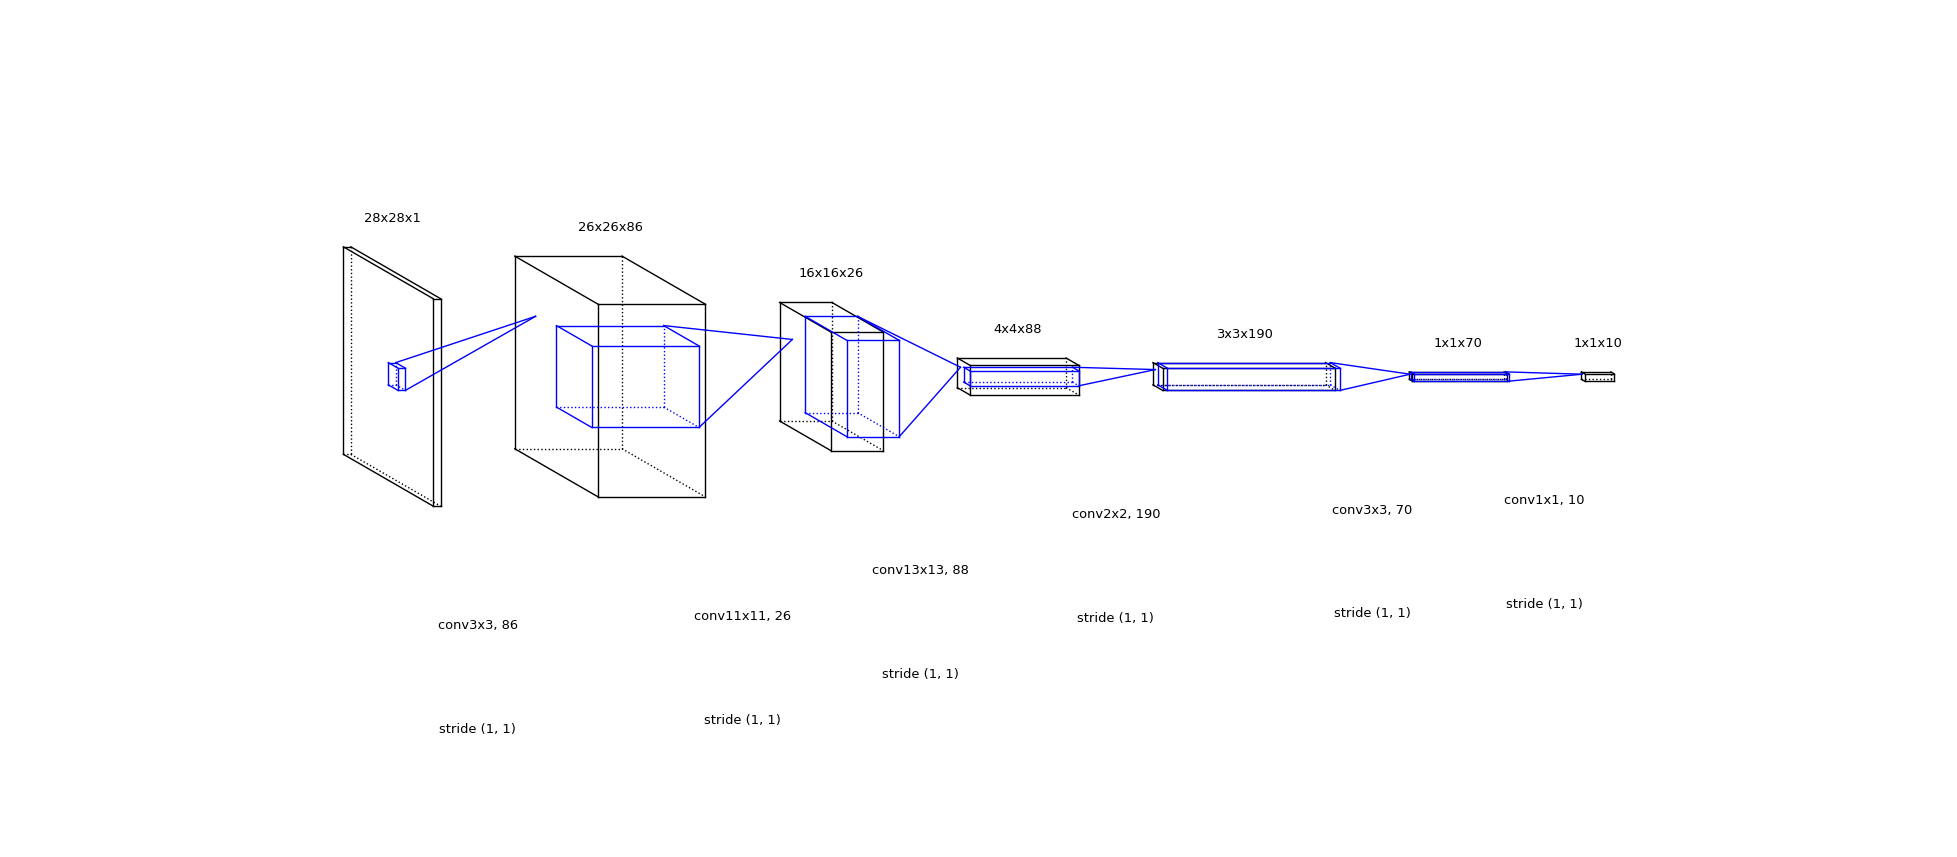

In [ ]:
wb.init(project="Simple98");
c = wb.config

c.h = 0.1
c.b = 128
c.layers = 6 
c.epochs = 5000

c.f_s = [3,11,13,2,3,1]        #Size of Each Filters 
c.f_n = [1,86,26,88,190,70,10] #Number of Filters

drawnet(X.shape[2],c.f_n,c.f_s)
log_arch()
wb.log({"example": wb.Image(plt)})

w = [ GPU(randn_trunc((c.f_n[i+1],c.f_n[i],c.f_s[i],c.f_s[i]))) for i in range(c.layers) ]

for i in range(c.epochs):

    x,y = get_batch('train')

    loss = cross_entropy(softmax(model(x,w)),y)

    loss.backward()

    gradient_step(w)
   
    if (i+1) % 100 == 0:

        make_plots()

In [ ]:
acc(model(X[0:5000],w),Y[0:5000])

0.9868

In [ ]:
acc(model(X_test,w),Y_test)

0.9804